# - GoogleNet(inception v1)

https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/

In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
img_dir = 'data/Images3'
categories = os.listdir(img_dir)
num_classes = len(categories)

In [3]:
image_w = 224
image_h = 224

In [4]:
X = []
y = []

for index, breed in enumerate(categories):
    label = [0 for i in range(num_classes)]
    label[index] = 1

    image_dir = img_dir + "/" + breed
    files = glob.glob(image_dir+"/*.jpg")
    print(index, ")", breed, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

0 ) n02085620-Chihuahua  파일 길이 :  152
1 ) n02085782-Japanese_spaniel  파일 길이 :  185
2 ) n02085936-Maltese_dog  파일 길이 :  252
3 ) n02086079-Pekinese  파일 길이 :  149
4 ) n02086240-Shih-Tzu  파일 길이 :  214
5 ) n02086646-Blenheim_spaniel  파일 길이 :  188
6 ) n02086910-papillon  파일 길이 :  196
7 ) n02088364-beagle  파일 길이 :  195
8 ) n02088466-bloodhound  파일 길이 :  187
9 ) n02089078-black-and-tan_coonhound  파일 길이 :  159
10 ) n02089867-Walker_hound  파일 길이 :  153
11 ) n02089973-English_foxhound  파일 길이 :  157
12 ) n02091032-Italian_greyhound  파일 길이 :  182
13 ) n02091134-whippet  파일 길이 :  187
14 ) n02093256-Staffordshire_bullterrier  파일 길이 :  155
15 ) n02093647-Bedlington_terrier  파일 길이 :  182
16 ) n02094258-Norwich_terrier  파일 길이 :  185
17 ) n02094433-Yorkshire_terrier  파일 길이 :  164
18 ) n02096294-Australian_terrier  파일 길이 :  196
19 ) n02096585-Boston_bull  파일 길이 :  182
20 ) n02097047-miniature_schnauzer  파일 길이 :  154
21 ) n02097209-standard_schnauzer  파일 길이 :  155
22 ) n02097658-silky_terrier  파일 길이 :  183

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
n = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(n)

In [7]:
X = X[n]
y = y[n]

In [8]:
print("Images shape after shuffling = ",X.shape,"\nLabels shape after shuffling = ",y.shape)

Images shape after shuffling =  (11411, 224, 224, 3) 
Labels shape after shuffling =  (11411, 65)


In [9]:
X = X.astype(np.float32)
y = y.astype(np.int32)
X = X/255.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [11]:
print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (8215, 224, 224, 3)
y_train shape =  (8215, 65)

x_val shape =  (913, 224, 224, 3)
y_val shape =  (913, 65)

x_test shape =  (2283, 224, 224, 3)
y_test shape =  (2283, 65)


In [12]:
image_generator = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    zoom_range = 0.25,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

In [13]:
image_generator.fit(x_train)

In [14]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [15]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [16]:
input_layer = Input(shape=(image_w, image_h, 3))

x = Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu', name='conv_1_5x5/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=48,
                     filters_3x3=64,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=48,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=24,
                     filters_pool_proj=32,
                     name='inception_4a')


x1 = AveragePooling2D((3, 3), strides=3)(x)
x1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(num_classes, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=96,
                     filters_3x3_reduce=64,
                     filters_3x3=144,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')


x2 = AveragePooling2D((3, 3), strides=3)(x)
x2 = Conv2D(64, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(num_classes, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=80,
                     filters_3x3=160,
                     filters_5x5_reduce=24,
                     filters_5x5=96,
                     filters_pool_proj=96,
                     name='inception_4c')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=80,
                     filters_3x3=160,
                     filters_5x5_reduce=24,
                     filters_5x5=96,
                     filters_pool_proj=96,
                     name='inception_5')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(num_classes, activation='softmax', name='output')(x)

In [17]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_5x5/2 (Conv2D)           (None, 112, 112, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 32)   0           conv_1_5x5/2[0][0]               
__________________________________________________________________________________________________
conv_2_3x3/1 (Conv2D)           (None, 56, 56, 64)   18496       max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [18]:
model.compile(optimizer="adam", loss= 'categorical_crossentropy', metrics=["accuracy"])
K.set_value(model.optimizer.learning_rate, 0.0001)

In [19]:
early_stopping= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 10)
model_checkPoint = ModelCheckpoint('GoogleNet.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

In [20]:
history = model.fit(image_generator.flow(x_train, y_train, batch_size=128), steps_per_epoch=x_train.shape[0]/200, epochs=500, shuffle=True, callbacks=[early_stopping, model_checkPoint], validation_data=(x_val, y_val))

Epoch 1/500
42/41 [==============================] - ETA: -4s - loss: 12.6732 - output_loss: 4.2517 - auxilliary_output_1_loss: 4.2188 - auxilliary_output_2_loss: 4.2027 - output_accuracy: 0.0159 - auxilliary_output_1_accuracy: 0.0156 - auxilliary_output_2_accuracy: 0.0167
Epoch 00001: val_loss improved from inf to 12.51534, saving model to GoogleNet.h5
42/41 [==============================] - 231s 5s/step - loss: 12.6732 - output_loss: 4.2517 - auxilliary_output_1_loss: 4.2188 - auxilliary_output_2_loss: 4.2027 - output_accuracy: 0.0159 - auxilliary_output_1_accuracy: 0.0156 - auxilliary_output_2_accuracy: 0.0167 - val_loss: 12.5153 - val_output_loss: 4.1733 - val_auxilliary_output_1_loss: 4.1700 - val_auxilliary_output_2_loss: 4.1720 - val_output_accuracy: 0.0252 - val_auxilliary_output_1_accuracy: 0.0175 - val_auxilliary_output_2_accuracy: 0.0153
Epoch 2/500
42/41 [==============================] - ETA: -5s - loss: 12.5463 - output_loss: 4.1992 - auxilliary_output_1_loss: 4.1713 - a

Epoch 11/500
42/41 [==============================] - ETA: -3s - loss: 12.2688 - output_loss: 4.1156 - auxilliary_output_1_loss: 4.0646 - auxilliary_output_2_loss: 4.0886 - output_accuracy: 0.0326 - auxilliary_output_1_accuracy: 0.0381 - auxilliary_output_2_accuracy: 0.0307
Epoch 00011: val_loss improved from 12.16122 to 12.13730, saving model to GoogleNet.h5
42/41 [==============================] - 148s 4s/step - loss: 12.2688 - output_loss: 4.1156 - auxilliary_output_1_loss: 4.0646 - auxilliary_output_2_loss: 4.0886 - output_accuracy: 0.0326 - auxilliary_output_1_accuracy: 0.0381 - auxilliary_output_2_accuracy: 0.0307 - val_loss: 12.1373 - val_output_loss: 4.0811 - val_auxilliary_output_1_loss: 4.0129 - val_auxilliary_output_2_loss: 4.0433 - val_output_accuracy: 0.0361 - val_auxilliary_output_1_accuracy: 0.0581 - val_auxilliary_output_2_accuracy: 0.0548
Epoch 12/500
42/41 [==============================] - ETA: -3s - loss: 12.2476 - output_loss: 4.1070 - auxilliary_output_1_loss: 4.0

Epoch 21/500
42/41 [==============================] - ETA: -3s - loss: 11.8595 - output_loss: 3.9875 - auxilliary_output_1_loss: 3.9335 - auxilliary_output_2_loss: 3.9384 - output_accuracy: 0.0486 - auxilliary_output_1_accuracy: 0.0588 - auxilliary_output_2_accuracy: 0.0539
Epoch 00021: val_loss improved from 11.66769 to 11.60923, saving model to GoogleNet.h5
42/41 [==============================] - 147s 4s/step - loss: 11.8595 - output_loss: 3.9875 - auxilliary_output_1_loss: 3.9335 - auxilliary_output_2_loss: 3.9384 - output_accuracy: 0.0486 - auxilliary_output_1_accuracy: 0.0588 - auxilliary_output_2_accuracy: 0.0539 - val_loss: 11.6092 - val_output_loss: 3.9317 - val_auxilliary_output_1_loss: 3.8316 - val_auxilliary_output_2_loss: 3.8459 - val_output_accuracy: 0.0690 - val_auxilliary_output_1_accuracy: 0.0811 - val_auxilliary_output_2_accuracy: 0.0745
Epoch 22/500
42/41 [==============================] - ETA: -3s - loss: 11.8348 - output_loss: 3.9771 - auxilliary_output_1_loss: 3.9

Epoch 31/500
42/41 [==============================] - ETA: -3s - loss: 11.5787 - output_loss: 3.8791 - auxilliary_output_1_loss: 3.8492 - auxilliary_output_2_loss: 3.8505 - output_accuracy: 0.0590 - auxilliary_output_1_accuracy: 0.0694 - auxilliary_output_2_accuracy: 0.0673
Epoch 00031: val_loss improved from 11.35646 to 11.33924, saving model to GoogleNet.h5
42/41 [==============================] - 145s 3s/step - loss: 11.5787 - output_loss: 3.8791 - auxilliary_output_1_loss: 3.8492 - auxilliary_output_2_loss: 3.8505 - output_accuracy: 0.0590 - auxilliary_output_1_accuracy: 0.0694 - auxilliary_output_2_accuracy: 0.0673 - val_loss: 11.3392 - val_output_loss: 3.8306 - val_auxilliary_output_1_loss: 3.7513 - val_auxilliary_output_2_loss: 3.7574 - val_output_accuracy: 0.0821 - val_auxilliary_output_1_accuracy: 0.0964 - val_auxilliary_output_2_accuracy: 0.0964
Epoch 32/500
42/41 [==============================] - ETA: -3s - loss: 11.5474 - output_loss: 3.8706 - auxilliary_output_1_loss: 3.8

Epoch 41/500
42/41 [==============================] - ETA: -3s - loss: 11.3339 - output_loss: 3.7795 - auxilliary_output_1_loss: 3.7801 - auxilliary_output_2_loss: 3.7743 - output_accuracy: 0.0784 - auxilliary_output_1_accuracy: 0.0839 - auxilliary_output_2_accuracy: 0.0765
Epoch 00041: val_loss did not improve from 11.00353
42/41 [==============================] - 145s 3s/step - loss: 11.3339 - output_loss: 3.7795 - auxilliary_output_1_loss: 3.7801 - auxilliary_output_2_loss: 3.7743 - output_accuracy: 0.0784 - auxilliary_output_1_accuracy: 0.0839 - auxilliary_output_2_accuracy: 0.0765 - val_loss: 11.2061 - val_output_loss: 3.7758 - val_auxilliary_output_1_loss: 3.7238 - val_auxilliary_output_2_loss: 3.7065 - val_output_accuracy: 0.0854 - val_auxilliary_output_1_accuracy: 0.1194 - val_auxilliary_output_2_accuracy: 0.1008
Epoch 42/500
42/41 [==============================] - ETA: -3s - loss: 11.3343 - output_loss: 3.7743 - auxilliary_output_1_loss: 3.7891 - auxilliary_output_2_loss: 3.7

Epoch 51/500
42/41 [==============================] - ETA: -3s - loss: 11.0747 - output_loss: 3.6731 - auxilliary_output_1_loss: 3.7102 - auxilliary_output_2_loss: 3.6914 - output_accuracy: 0.0973 - auxilliary_output_1_accuracy: 0.0911 - auxilliary_output_2_accuracy: 0.0901
Epoch 00051: val_loss did not improve from 10.67969
42/41 [==============================] - 144s 3s/step - loss: 11.0747 - output_loss: 3.6731 - auxilliary_output_1_loss: 3.7102 - auxilliary_output_2_loss: 3.6914 - output_accuracy: 0.0973 - auxilliary_output_1_accuracy: 0.0911 - auxilliary_output_2_accuracy: 0.0901 - val_loss: 10.7294 - val_output_loss: 3.5854 - val_auxilliary_output_1_loss: 3.5880 - val_auxilliary_output_2_loss: 3.5560 - val_output_accuracy: 0.1117 - val_auxilliary_output_1_accuracy: 0.1271 - val_auxilliary_output_2_accuracy: 0.1150
Epoch 52/500
42/41 [==============================] - ETA: -3s - loss: 11.0461 - output_loss: 3.6640 - auxilliary_output_1_loss: 3.7122 - auxilliary_output_2_loss: 3.6

Epoch 61/500
42/41 [==============================] - ETA: -3s - loss: 10.8112 - output_loss: 3.5687 - auxilliary_output_1_loss: 3.6442 - auxilliary_output_2_loss: 3.5984 - output_accuracy: 0.0999 - auxilliary_output_1_accuracy: 0.0934 - auxilliary_output_2_accuracy: 0.1075
Epoch 00061: val_loss improved from 10.49244 to 10.47551, saving model to GoogleNet.h5
42/41 [==============================] - 151s 4s/step - loss: 10.8112 - output_loss: 3.5687 - auxilliary_output_1_loss: 3.6442 - auxilliary_output_2_loss: 3.5984 - output_accuracy: 0.0999 - auxilliary_output_1_accuracy: 0.0934 - auxilliary_output_2_accuracy: 0.1075 - val_loss: 10.4755 - val_output_loss: 3.4789 - val_auxilliary_output_1_loss: 3.5115 - val_auxilliary_output_2_loss: 3.4851 - val_output_accuracy: 0.1380 - val_auxilliary_output_1_accuracy: 0.1380 - val_auxilliary_output_2_accuracy: 0.1347
Epoch 62/500
42/41 [==============================] - ETA: -3s - loss: 10.8151 - output_loss: 3.5699 - auxilliary_output_1_loss: 3.6

Epoch 71/500
42/41 [==============================] - ETA: -3s - loss: 10.6927 - output_loss: 3.5148 - auxilliary_output_1_loss: 3.6124 - auxilliary_output_2_loss: 3.5656 - output_accuracy: 0.1169 - auxilliary_output_1_accuracy: 0.0979 - auxilliary_output_2_accuracy: 0.1028
Epoch 00071: val_loss improved from 10.29900 to 10.26386, saving model to GoogleNet.h5
42/41 [==============================] - 146s 3s/step - loss: 10.6927 - output_loss: 3.5148 - auxilliary_output_1_loss: 3.6124 - auxilliary_output_2_loss: 3.5656 - output_accuracy: 0.1169 - auxilliary_output_1_accuracy: 0.0979 - auxilliary_output_2_accuracy: 0.1028 - val_loss: 10.2639 - val_output_loss: 3.4050 - val_auxilliary_output_1_loss: 3.4576 - val_auxilliary_output_2_loss: 3.4013 - val_output_accuracy: 0.1380 - val_auxilliary_output_1_accuracy: 0.1435 - val_auxilliary_output_2_accuracy: 0.1566
Epoch 72/500
42/41 [==============================] - ETA: -3s - loss: 10.6872 - output_loss: 3.5258 - auxilliary_output_1_loss: 3.5

Epoch 81/500
42/41 [==============================] - ETA: -3s - loss: 10.5189 - output_loss: 3.4504 - auxilliary_output_1_loss: 3.5600 - auxilliary_output_2_loss: 3.5084 - output_accuracy: 0.1218 - auxilliary_output_1_accuracy: 0.1146 - auxilliary_output_2_accuracy: 0.1208
Epoch 00081: val_loss did not improve from 10.11025
42/41 [==============================] - 146s 3s/step - loss: 10.5189 - output_loss: 3.4504 - auxilliary_output_1_loss: 3.5600 - auxilliary_output_2_loss: 3.5084 - output_accuracy: 0.1218 - auxilliary_output_1_accuracy: 0.1146 - auxilliary_output_2_accuracy: 0.1208 - val_loss: 10.3761 - val_output_loss: 3.4376 - val_auxilliary_output_1_loss: 3.4999 - val_auxilliary_output_2_loss: 3.4386 - val_output_accuracy: 0.1468 - val_auxilliary_output_1_accuracy: 0.1358 - val_auxilliary_output_2_accuracy: 0.1468
Epoch 82/500
42/41 [==============================] - ETA: -3s - loss: 10.4962 - output_loss: 3.4454 - auxilliary_output_1_loss: 3.5487 - auxilliary_output_2_loss: 3.5

Epoch 91/500
42/41 [==============================] - ETA: -3s - loss: 10.3944 - output_loss: 3.4029 - auxilliary_output_1_loss: 3.5240 - auxilliary_output_2_loss: 3.4676 - output_accuracy: 0.1337 - auxilliary_output_1_accuracy: 0.1163 - auxilliary_output_2_accuracy: 0.1276
Epoch 00091: val_loss improved from 9.99143 to 9.93845, saving model to GoogleNet.h5
42/41 [==============================] - 148s 4s/step - loss: 10.3944 - output_loss: 3.4029 - auxilliary_output_1_loss: 3.5240 - auxilliary_output_2_loss: 3.4676 - output_accuracy: 0.1337 - auxilliary_output_1_accuracy: 0.1163 - auxilliary_output_2_accuracy: 0.1276 - val_loss: 9.9385 - val_output_loss: 3.2828 - val_auxilliary_output_1_loss: 3.3723 - val_auxilliary_output_2_loss: 3.2833 - val_output_accuracy: 0.1643 - val_auxilliary_output_1_accuracy: 0.1610 - val_auxilliary_output_2_accuracy: 0.1774
Epoch 92/500
42/41 [==============================] - ETA: -3s - loss: 10.3262 - output_loss: 3.3809 - auxilliary_output_1_loss: 3.5048

Epoch 101/500
42/41 [==============================] - ETA: -3s - loss: 10.2700 - output_loss: 3.3703 - auxilliary_output_1_loss: 3.4780 - auxilliary_output_2_loss: 3.4217 - output_accuracy: 0.1375 - auxilliary_output_1_accuracy: 0.1199 - auxilliary_output_2_accuracy: 0.1282
Epoch 00101: val_loss improved from 9.86121 to 9.80156, saving model to GoogleNet.h5
42/41 [==============================] - 146s 3s/step - loss: 10.2700 - output_loss: 3.3703 - auxilliary_output_1_loss: 3.4780 - auxilliary_output_2_loss: 3.4217 - output_accuracy: 0.1375 - auxilliary_output_1_accuracy: 0.1199 - auxilliary_output_2_accuracy: 0.1282 - val_loss: 9.8016 - val_output_loss: 3.2504 - val_auxilliary_output_1_loss: 3.3187 - val_auxilliary_output_2_loss: 3.2324 - val_output_accuracy: 0.1774 - val_auxilliary_output_1_accuracy: 0.1665 - val_auxilliary_output_2_accuracy: 0.1873
Epoch 102/500
42/41 [==============================] - ETA: -3s - loss: 10.2923 - output_loss: 3.3689 - auxilliary_output_1_loss: 3.48

Epoch 111/500
42/41 [==============================] - ETA: -3s - loss: 10.0449 - output_loss: 3.2817 - auxilliary_output_1_loss: 3.4266 - auxilliary_output_2_loss: 3.3366 - output_accuracy: 0.1548 - auxilliary_output_1_accuracy: 0.1311 - auxilliary_output_2_accuracy: 0.1525
Epoch 00111: val_loss did not improve from 9.69852
42/41 [==============================] - 148s 4s/step - loss: 10.0449 - output_loss: 3.2817 - auxilliary_output_1_loss: 3.4266 - auxilliary_output_2_loss: 3.3366 - output_accuracy: 0.1548 - auxilliary_output_1_accuracy: 0.1311 - auxilliary_output_2_accuracy: 0.1525 - val_loss: 9.7185 - val_output_loss: 3.2085 - val_auxilliary_output_1_loss: 3.2932 - val_auxilliary_output_2_loss: 3.2168 - val_output_accuracy: 0.1873 - val_auxilliary_output_1_accuracy: 0.1720 - val_auxilliary_output_2_accuracy: 0.1972
Epoch 112/500
42/41 [==============================] - ETA: -3s - loss: 10.1580 - output_loss: 3.3249 - auxilliary_output_1_loss: 3.4489 - auxilliary_output_2_loss: 3.3

Epoch 121/500
42/41 [==============================] - ETA: -3s - loss: 10.0365 - output_loss: 3.2785 - auxilliary_output_1_loss: 3.4202 - auxilliary_output_2_loss: 3.3378 - output_accuracy: 0.1548 - auxilliary_output_1_accuracy: 0.1375 - auxilliary_output_2_accuracy: 0.1434
Epoch 00121: val_loss improved from 9.56814 to 9.53130, saving model to GoogleNet.h5
42/41 [==============================] - 146s 3s/step - loss: 10.0365 - output_loss: 3.2785 - auxilliary_output_1_loss: 3.4202 - auxilliary_output_2_loss: 3.3378 - output_accuracy: 0.1548 - auxilliary_output_1_accuracy: 0.1375 - auxilliary_output_2_accuracy: 0.1434 - val_loss: 9.5313 - val_output_loss: 3.1288 - val_auxilliary_output_1_loss: 3.2423 - val_auxilliary_output_2_loss: 3.1602 - val_output_accuracy: 0.1829 - val_auxilliary_output_1_accuracy: 0.1818 - val_auxilliary_output_2_accuracy: 0.2004
Epoch 122/500
42/41 [==============================] - ETA: -3s - loss: 9.9165 - output_loss: 3.2197 - auxilliary_output_1_loss: 3.385

Epoch 131/500
42/41 [==============================] - ETA: -3s - loss: 9.9437 - output_loss: 3.2279 - auxilliary_output_1_loss: 3.4047 - auxilliary_output_2_loss: 3.3111 - output_accuracy: 0.1689 - auxilliary_output_1_accuracy: 0.1354 - auxilliary_output_2_accuracy: 0.1577
Epoch 00131: val_loss did not improve from 9.52749
42/41 [==============================] - 149s 4s/step - loss: 9.9437 - output_loss: 3.2279 - auxilliary_output_1_loss: 3.4047 - auxilliary_output_2_loss: 3.3111 - output_accuracy: 0.1689 - auxilliary_output_1_accuracy: 0.1354 - auxilliary_output_2_accuracy: 0.1577 - val_loss: 9.6311 - val_output_loss: 3.1657 - val_auxilliary_output_1_loss: 3.2882 - val_auxilliary_output_2_loss: 3.1772 - val_output_accuracy: 0.1982 - val_auxilliary_output_1_accuracy: 0.1763 - val_auxilliary_output_2_accuracy: 0.1982
Epoch 132/500
42/41 [==============================] - ETA: -3s - loss: 9.9302 - output_loss: 3.2376 - auxilliary_output_1_loss: 3.3916 - auxilliary_output_2_loss: 3.3010

Epoch 141/500
42/41 [==============================] - ETA: -3s - loss: 9.7799 - output_loss: 3.1830 - auxilliary_output_1_loss: 3.3467 - auxilliary_output_2_loss: 3.2502 - output_accuracy: 0.1810 - auxilliary_output_1_accuracy: 0.1518 - auxilliary_output_2_accuracy: 0.1605
Epoch 00141: val_loss did not improve from 9.37230
42/41 [==============================] - 147s 3s/step - loss: 9.7799 - output_loss: 3.1830 - auxilliary_output_1_loss: 3.3467 - auxilliary_output_2_loss: 3.2502 - output_accuracy: 0.1810 - auxilliary_output_1_accuracy: 0.1518 - auxilliary_output_2_accuracy: 0.1605 - val_loss: 9.5292 - val_output_loss: 3.1368 - val_auxilliary_output_1_loss: 3.2352 - val_auxilliary_output_2_loss: 3.1572 - val_output_accuracy: 0.1993 - val_auxilliary_output_1_accuracy: 0.1961 - val_auxilliary_output_2_accuracy: 0.2070
Epoch 142/500
42/41 [==============================] - ETA: -3s - loss: 9.7515 - output_loss: 3.1606 - auxilliary_output_1_loss: 3.3483 - auxilliary_output_2_loss: 3.2426

Epoch 151/500
42/41 [==============================] - ETA: -3s - loss: 9.5796 - output_loss: 3.0884 - auxilliary_output_1_loss: 3.2998 - auxilliary_output_2_loss: 3.1914 - output_accuracy: 0.1952 - auxilliary_output_1_accuracy: 0.1628 - auxilliary_output_2_accuracy: 0.1728
Epoch 00151: val_loss did not improve from 9.31187
42/41 [==============================] - 147s 4s/step - loss: 9.5796 - output_loss: 3.0884 - auxilliary_output_1_loss: 3.2998 - auxilliary_output_2_loss: 3.1914 - output_accuracy: 0.1952 - auxilliary_output_1_accuracy: 0.1628 - auxilliary_output_2_accuracy: 0.1728 - val_loss: 9.3478 - val_output_loss: 3.0615 - val_auxilliary_output_1_loss: 3.1817 - val_auxilliary_output_2_loss: 3.1047 - val_output_accuracy: 0.2125 - val_auxilliary_output_1_accuracy: 0.2004 - val_auxilliary_output_2_accuracy: 0.2103
Epoch 152/500
42/41 [==============================] - ETA: -3s - loss: 9.5910 - output_loss: 3.1052 - auxilliary_output_1_loss: 3.2897 - auxilliary_output_2_loss: 3.1961

Epoch 161/500
42/41 [==============================] - ETA: -3s - loss: 9.5195 - output_loss: 3.0692 - auxilliary_output_1_loss: 3.2772 - auxilliary_output_2_loss: 3.1732 - output_accuracy: 0.2054 - auxilliary_output_1_accuracy: 0.1631 - auxilliary_output_2_accuracy: 0.1808
Epoch 00161: val_loss did not improve from 9.26120
42/41 [==============================] - 149s 4s/step - loss: 9.5195 - output_loss: 3.0692 - auxilliary_output_1_loss: 3.2772 - auxilliary_output_2_loss: 3.1732 - output_accuracy: 0.2054 - auxilliary_output_1_accuracy: 0.1631 - auxilliary_output_2_accuracy: 0.1808 - val_loss: 9.2752 - val_output_loss: 3.0297 - val_auxilliary_output_1_loss: 3.1632 - val_auxilliary_output_2_loss: 3.0824 - val_output_accuracy: 0.2344 - val_auxilliary_output_1_accuracy: 0.1950 - val_auxilliary_output_2_accuracy: 0.2081
Epoch 162/500
42/41 [==============================] - ETA: -3s - loss: 9.4962 - output_loss: 3.0702 - auxilliary_output_1_loss: 3.2826 - auxilliary_output_2_loss: 3.1433

Epoch 171/500
42/41 [==============================] - ETA: -3s - loss: 9.4710 - output_loss: 3.0553 - auxilliary_output_1_loss: 3.2673 - auxilliary_output_2_loss: 3.1484 - output_accuracy: 0.1957 - auxilliary_output_1_accuracy: 0.1641 - auxilliary_output_2_accuracy: 0.1821
Epoch 00171: val_loss improved from 9.18647 to 9.18018, saving model to GoogleNet.h5
42/41 [==============================] - 149s 4s/step - loss: 9.4710 - output_loss: 3.0553 - auxilliary_output_1_loss: 3.2673 - auxilliary_output_2_loss: 3.1484 - output_accuracy: 0.1957 - auxilliary_output_1_accuracy: 0.1641 - auxilliary_output_2_accuracy: 0.1821 - val_loss: 9.1802 - val_output_loss: 3.0087 - val_auxilliary_output_1_loss: 3.1222 - val_auxilliary_output_2_loss: 3.0493 - val_output_accuracy: 0.2180 - val_auxilliary_output_1_accuracy: 0.2114 - val_auxilliary_output_2_accuracy: 0.2114
Epoch 172/500
42/41 [==============================] - ETA: -3s - loss: 9.3804 - output_loss: 3.0177 - auxilliary_output_1_loss: 3.2421 

Epoch 181/500
42/41 [==============================] - ETA: -3s - loss: 9.3049 - output_loss: 3.0034 - auxilliary_output_1_loss: 3.2134 - auxilliary_output_2_loss: 3.0881 - output_accuracy: 0.2037 - auxilliary_output_1_accuracy: 0.1715 - auxilliary_output_2_accuracy: 0.1962
Epoch 00181: val_loss improved from 9.13084 to 9.06002, saving model to GoogleNet.h5
42/41 [==============================] - 149s 4s/step - loss: 9.3049 - output_loss: 3.0034 - auxilliary_output_1_loss: 3.2134 - auxilliary_output_2_loss: 3.0881 - output_accuracy: 0.2037 - auxilliary_output_1_accuracy: 0.1715 - auxilliary_output_2_accuracy: 0.1962 - val_loss: 9.0600 - val_output_loss: 2.9495 - val_auxilliary_output_1_loss: 3.0985 - val_auxilliary_output_2_loss: 3.0120 - val_output_accuracy: 0.2388 - val_auxilliary_output_1_accuracy: 0.2026 - val_auxilliary_output_2_accuracy: 0.2180
Epoch 182/500
42/41 [==============================] - ETA: -3s - loss: 9.2853 - output_loss: 2.9937 - auxilliary_output_1_loss: 3.2042 

Epoch 191/500
42/41 [==============================] - ETA: -3s - loss: 9.1816 - output_loss: 2.9490 - auxilliary_output_1_loss: 3.1845 - auxilliary_output_2_loss: 3.0481 - output_accuracy: 0.2233 - auxilliary_output_1_accuracy: 0.1764 - auxilliary_output_2_accuracy: 0.2013
Epoch 00191: val_loss did not improve from 9.03128
42/41 [==============================] - 148s 4s/step - loss: 9.1816 - output_loss: 2.9490 - auxilliary_output_1_loss: 3.1845 - auxilliary_output_2_loss: 3.0481 - output_accuracy: 0.2233 - auxilliary_output_1_accuracy: 0.1764 - auxilliary_output_2_accuracy: 0.2013 - val_loss: 9.0755 - val_output_loss: 2.9653 - val_auxilliary_output_1_loss: 3.1007 - val_auxilliary_output_2_loss: 3.0095 - val_output_accuracy: 0.2256 - val_auxilliary_output_1_accuracy: 0.2070 - val_auxilliary_output_2_accuracy: 0.2202
Epoch 192/500
42/41 [==============================] - ETA: -3s - loss: 9.1426 - output_loss: 2.9330 - auxilliary_output_1_loss: 3.1750 - auxilliary_output_2_loss: 3.0346

Epoch 201/500
42/41 [==============================] - ETA: -3s - loss: 9.0734 - output_loss: 2.9196 - auxilliary_output_1_loss: 3.1488 - auxilliary_output_2_loss: 3.0051 - output_accuracy: 0.2241 - auxilliary_output_1_accuracy: 0.1825 - auxilliary_output_2_accuracy: 0.2132
Epoch 00201: val_loss improved from 8.99171 to 8.96667, saving model to GoogleNet.h5
42/41 [==============================] - 150s 4s/step - loss: 9.0734 - output_loss: 2.9196 - auxilliary_output_1_loss: 3.1488 - auxilliary_output_2_loss: 3.0051 - output_accuracy: 0.2241 - auxilliary_output_1_accuracy: 0.1825 - auxilliary_output_2_accuracy: 0.2132 - val_loss: 8.9667 - val_output_loss: 2.9317 - val_auxilliary_output_1_loss: 3.0615 - val_auxilliary_output_2_loss: 2.9734 - val_output_accuracy: 0.2497 - val_auxilliary_output_1_accuracy: 0.2267 - val_auxilliary_output_2_accuracy: 0.2311
Epoch 202/500
42/41 [==============================] - ETA: -3s - loss: 9.1002 - output_loss: 2.9164 - auxilliary_output_1_loss: 3.1636 

Epoch 211/500
42/41 [==============================] - ETA: -3s - loss: 9.0774 - output_loss: 2.9086 - auxilliary_output_1_loss: 3.1537 - auxilliary_output_2_loss: 3.0151 - output_accuracy: 0.2327 - auxilliary_output_1_accuracy: 0.1828 - auxilliary_output_2_accuracy: 0.2072
Epoch 00211: val_loss did not improve from 8.90896
42/41 [==============================] - 149s 4s/step - loss: 9.0774 - output_loss: 2.9086 - auxilliary_output_1_loss: 3.1537 - auxilliary_output_2_loss: 3.0151 - output_accuracy: 0.2327 - auxilliary_output_1_accuracy: 0.1828 - auxilliary_output_2_accuracy: 0.2072 - val_loss: 8.9625 - val_output_loss: 2.9264 - val_auxilliary_output_1_loss: 3.0603 - val_auxilliary_output_2_loss: 2.9759 - val_output_accuracy: 0.2475 - val_auxilliary_output_1_accuracy: 0.2191 - val_auxilliary_output_2_accuracy: 0.2366
Epoch 212/500
42/41 [==============================] - ETA: -3s - loss: 8.9376 - output_loss: 2.8615 - auxilliary_output_1_loss: 3.1019 - auxilliary_output_2_loss: 2.9742

Epoch 00220: early stopping


In [21]:
model.load_weights('GoogleNet.h5')

In [22]:
loss, output_loss, auxilliary_output_1_loss, auxilliary_output_2_loss, output_accuracy, auxilliary_output_1_accuracy, auxilliary_output_2_accuracy = model.evaluate(x_test, [y_test, y_test, y_test])
print('\nLoss: {:.4f}, Acc: {:.4f}'.format(auxilliary_output_2_loss, auxilliary_output_2_accuracy))

72/72 [==============================] - 14s 197ms/step - loss: 9.1941 - output_loss: 3.0149 - auxilliary_output_1_loss: 3.1234 - auxilliary_output_2_loss: 3.0558 - output_accuracy: 0.2120 - auxilliary_output_1_accuracy: 0.1835 - auxilliary_output_2_accuracy: 0.2120

Loss: 3.0558, Acc: 0.2120


In [23]:
def plot_loss(history):
    plt.plot(history.history['auxilliary_output_2_loss'])
    plt.plot(history.history['val_auxilliary_output_2_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

def plot_acc(history):
    plt.plot(history.history['auxilliary_output_2_accuracy'])
    plt.plot(history.history['val_auxilliary_output_2_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

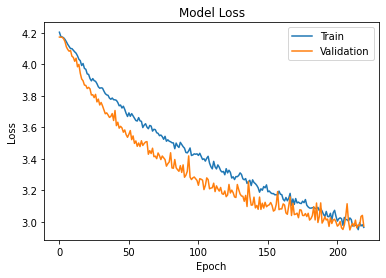

In [24]:
plot_loss(history)
plt.show()

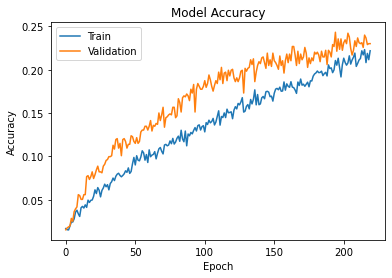

In [25]:
plot_acc(history)
plt.show()

In [26]:
predictions = model.predict(x_test)

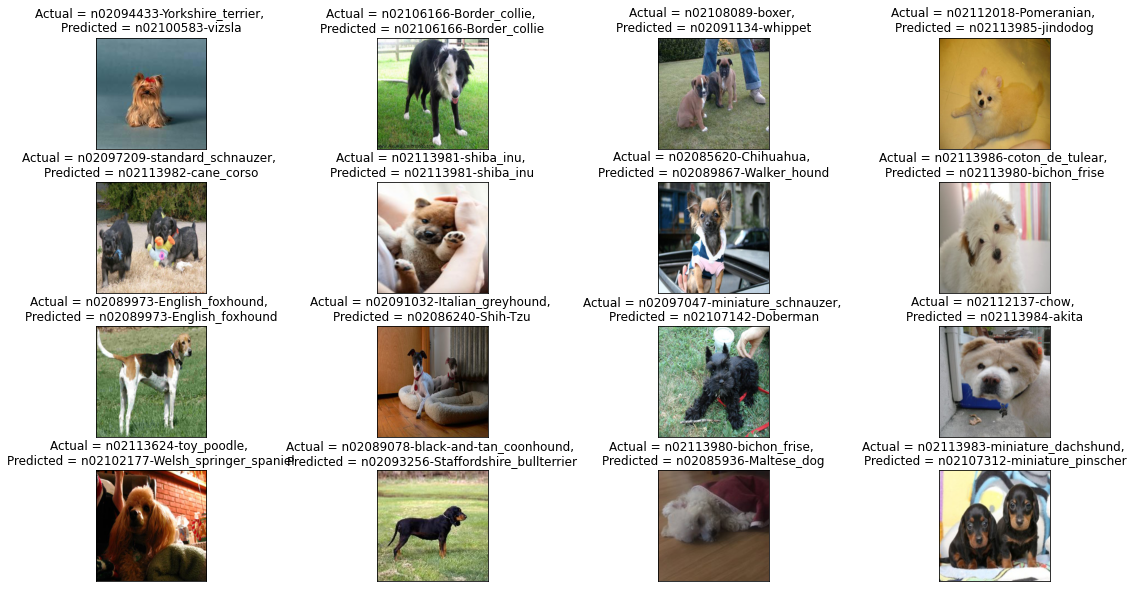

In [27]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(16):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(4, 4, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, \nPredicted = {}'.format(categories[np.argpartition(y_test[r[0]],-1)[-1:][0]] , categories[np.argpartition(predictions[2][r[0]],-1)[-1:][0]]))
    plt.xticks([]) , plt.yticks([])

plt.show()